In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib as mpl
from jax.scipy import stats

In [3]:
%config InlineBackend.figure_format = 'retina'

# temp and lr schedule

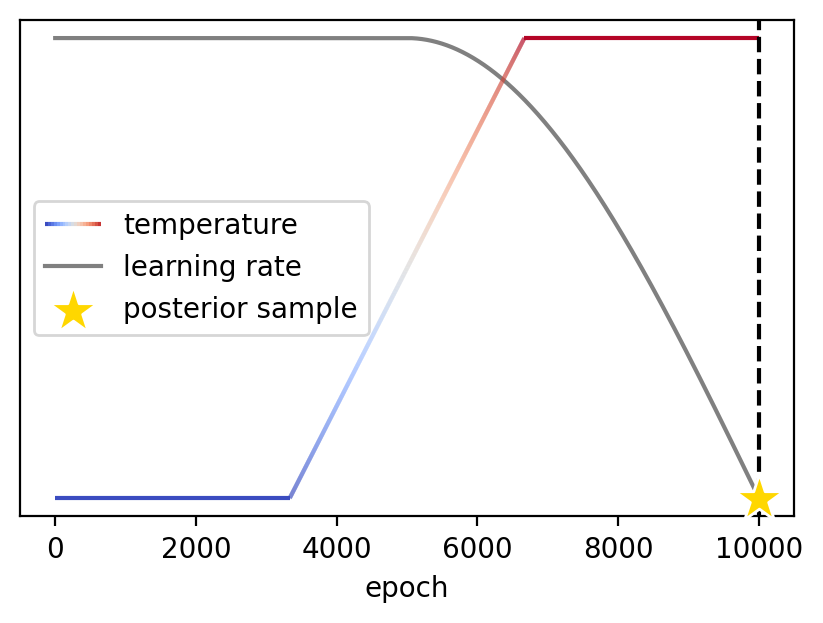

In [4]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')

# plot lr
n_epochs = 10_000
epoch = jnp.arange(n_epochs)
lr = jnp.where(epoch < n_epochs/2, 1, jnp.sin(jnp.pi*(epoch/n_epochs)))
ax.plot(epoch, lr, c='gray', label='learning rate')

# plot temp
T = jnp.clip(3*(epoch/n_epochs) - 1, 0, 1)
points = jnp.stack([epoch, T], 1)
segments = jnp.stack([points[:-1], points[1:]], axis=1)
lc = mpl.collections.LineCollection(segments, cmap='coolwarm', norm=plt.Normalize(0, 1))
lc.set_array(T)
ax.add_collection(lc)

# star
ax.scatter([n_epochs], [-0.002], color='gold', marker='*', s=330, zorder=5, clip_on=False, edgecolor='white', label='posterior sample')
ax.axvline(n_epochs, color='black', ls='--')

# legend
def make_gradient_line(x0, y0, w, h, n_rectangles=50):
    colors = mpl.cm.coolwarm(jnp.linspace(0, 1, n_rectangles))
    x = jnp.linspace(x0, x0+w, n_rectangles)
    y = jnp.repeat((y0 + h/2), n_rectangles)
    points = jnp.stack([x, y], 1)
    segments = jnp.stack([points[:-1], points[1:]], axis=1)
    line_collection = mpl.collections.LineCollection(segments, edgecolors=colors)
    return line_collection
class GradientLegendHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        line_collection = make_gradient_line(x0, y0, w, h, 20)
        handlebox.add_artist(line_collection)
        return line_collection
handles, labels = ax.get_legend_handles_labels()
handles = (mpl.lines.Line2D([0], [0], label='temperature'), *handles)
ax.legend(loc='center left', handles=handles, handler_map={handles[0]: GradientLegendHandler()})

ax.set_ylim((-0.04, 1.04))
ax.set_xlabel('epoch')
ax.set(yticklabels=[])
ax.tick_params(left=False)
# plt.savefig('../plots/sghmc_schedule.pdf')
plt.show()

# NDG visualization

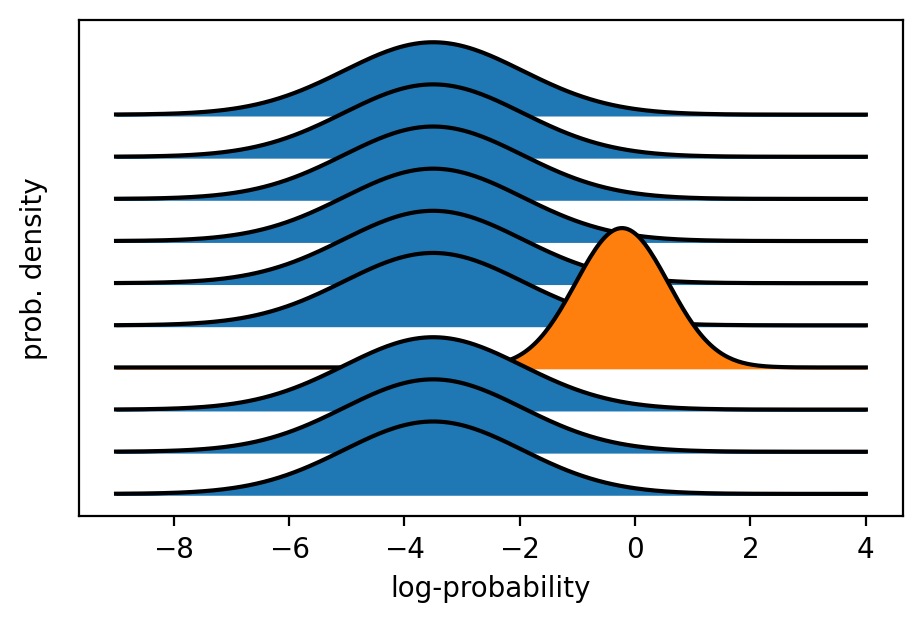

In [5]:
# ridgeline plot of Dirichlet Gaussian
fig, ax = plt.subplots(figsize=(4.5, 3), layout='constrained')

n_class = 10
label = 3
alpha = (0.1 * jnp.ones(n_class)).at[label].add(1)
var = jnp.log(1 / alpha + 1)
mean = jnp.log(alpha) - var / 2
overlap = 0.85 # overlap between distributions, range [0, 1]
n_points = 300
x = jnp.linspace(-9, 4, n_points)
for i in range(n_class):
    y0 = i * (1-overlap) * jnp.ones(n_points)
    y = stats.norm.pdf(x, mean[i], jnp.sqrt(var[i]))
    color = 'C1' if i == label else 'C0'
    ax.fill_between(x, y0, y0+y, zorder=-i, color=color)
    ax.plot(x, y0+y, c='black', zorder=-i)

ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.set_xlabel('log-probability')
ax.set_ylabel('prob. density')
# plt.savefig('../plots/ndg_visualized.pdf')
plt.show()